In [2]:
import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors

from matplotlib import pyplot as plt
import seaborn as sns


In [3]:
# TODO: Add total spendings column

In [4]:
# 1) FRESH: annual spending (m.u.) on fresh products (Continuous);
# 2) MILK: annual spending (m.u.) on milk products (Continuous);
# 3) GROCERY: annual spending (m.u.) on grocery products (Continuous);
# 4) FROZEN: annual spending (m.u.) on frozen products (Continuous)
# 5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
# 6) DELICATESSEN: annual spending (m.u.) on and delicatessen products (Continuous);
# 7) CHANNEL: customers' Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
# 8) REGION: customers' Region - Lisnon, Oporto or Other (Nominal)
# Descriptive Statistics:

# (Minimum, Maximum, Mean, Std. Deviation)
# FRESH ( 3, 112151, 12000.30, 12647.329)
# MILK (55, 73498, 5796.27, 7380.377)
# GROCERY (3, 92780, 7951.28, 9503.163)
# FROZEN (25, 60869, 3071.93, 4854.673)
# DETERGENTS_PAPER (3, 40827, 2881.49, 4767.854)
# DELICATESSEN (3, 47943, 1524.87, 2820.106)

# REGION Frequency
# Lisbon 77
# Oporto 47
# Other Region 316
# Total 440

# CHANNEL Frequency
# Horeca 298
# Retail 142
# Total 440



# 1 Loading the Data, Preprocessing, Initial Data Analysis

In [5]:
df = pd.read_csv(r"https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv")
df = df.drop(columns=["Channel", "Region"])
df_og = df.copy()
df

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204
436,39228,1431,764,4510,93,2346
437,14531,15488,30243,437,14841,1867
438,10290,1981,2232,1038,168,2125


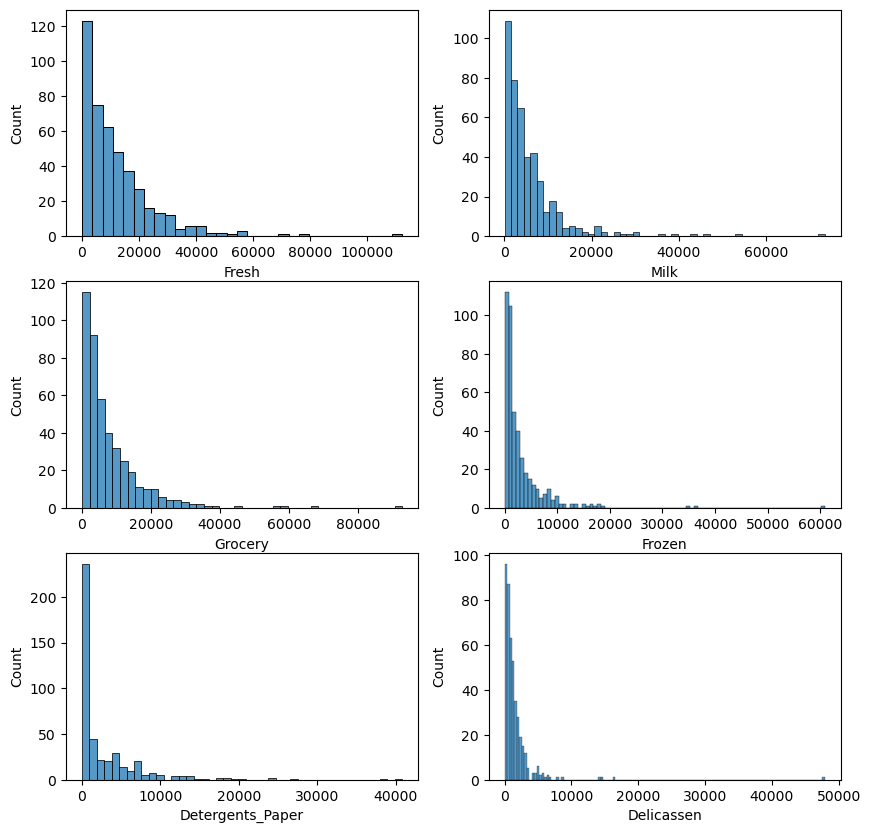

In [6]:
def plot_hist_cols():
    fig, axes = plt.subplots(3, 2, figsize=(10, 10))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        sns.histplot(df[col], ax=axes[i])


plot_hist_cols()


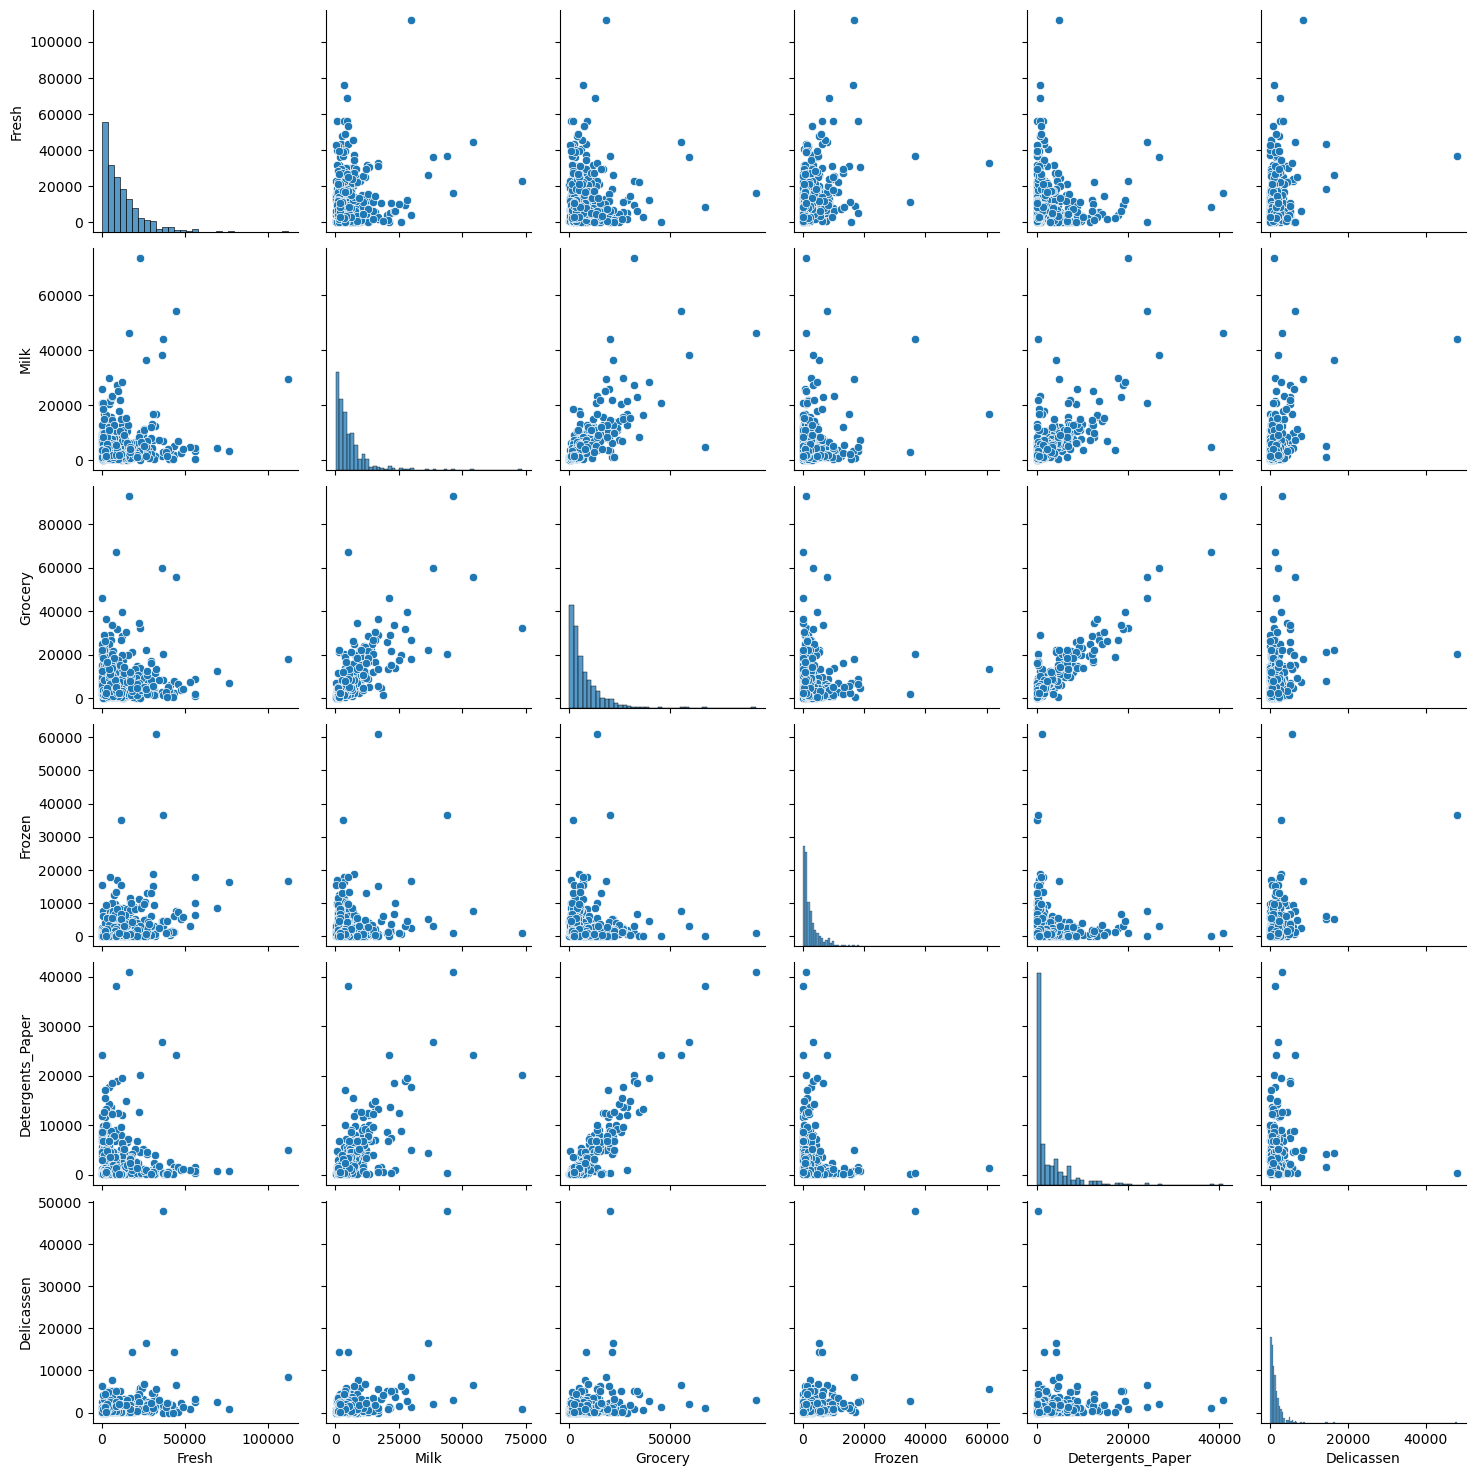

In [7]:
sns.pairplot(df)


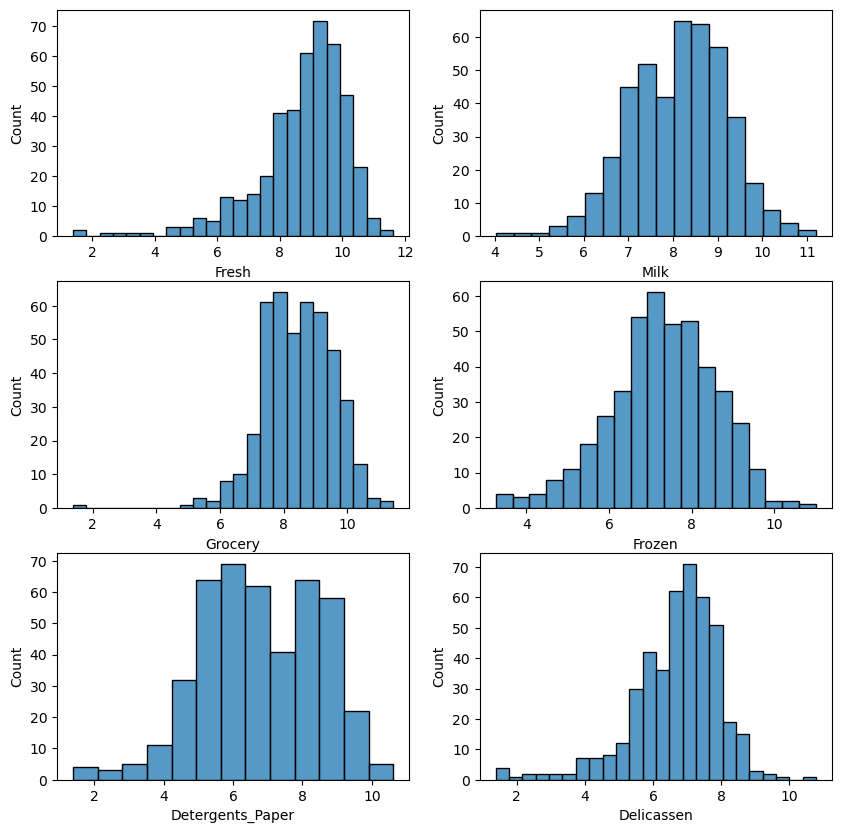

In [8]:
df = np.log(df + 1)
df_overview = df.copy()
plot_hist_cols()


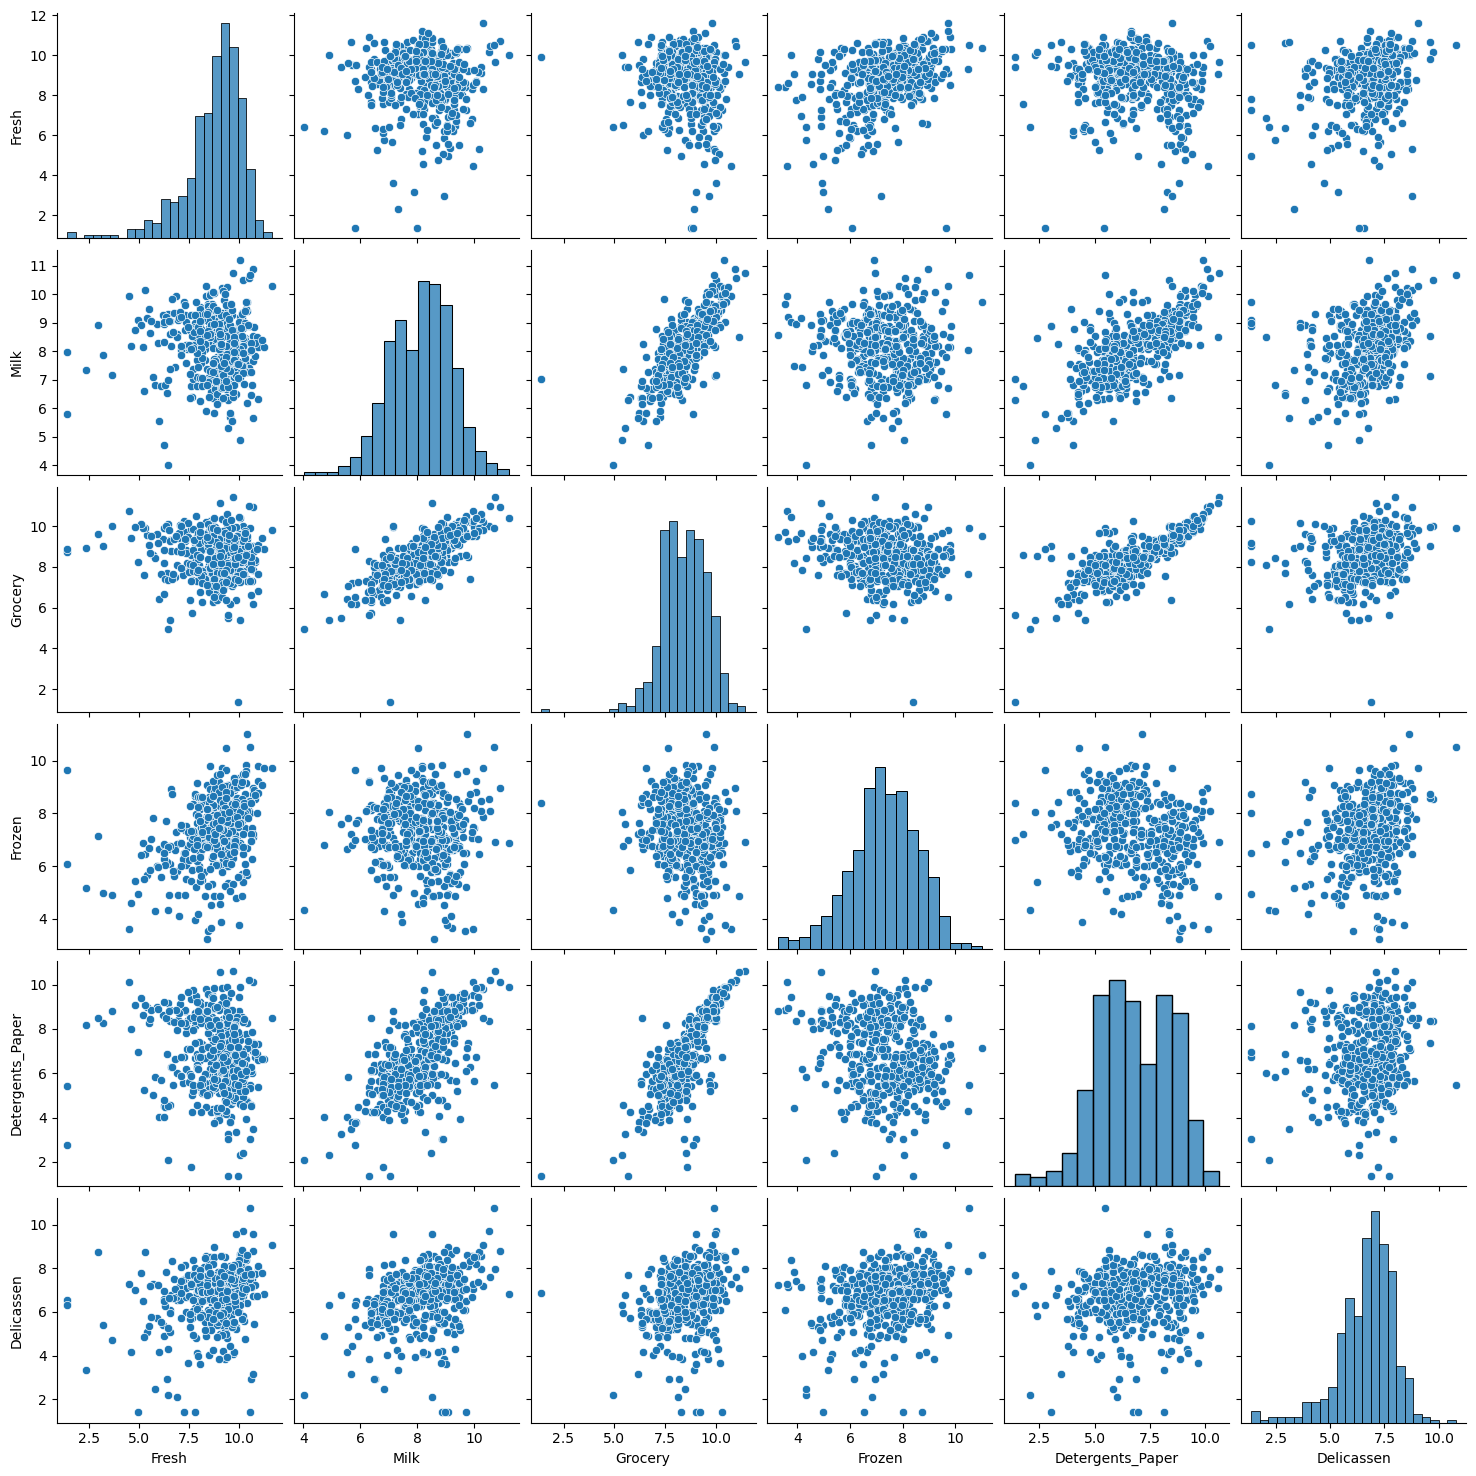

In [9]:
sns.pairplot(df)
# TODO: Add Correlation Plot and a column with total spendings
# Barplot/Pie chart with spendings from total spendings


# 2 Detecting Anomalies
## Hard-Min Score

In [10]:
nbrs = NearestNeighbors(n_neighbors=2, algorithm="ball_tree").fit(df)
distances, indices = nbrs.kneighbors(df)
df_overview["outlier_score_min"] = np.square(distances[:, 1])
df_overview.sort_values(by="outlier_score_min", ascending=False).head(10)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,outlier_score_min
338,1.386294,5.811141,8.856803,9.655154,2.772589,6.311735,24.462058
75,9.923241,7.037028,1.386294,8.391176,1.386294,6.883463,21.598732
154,6.434547,4.025352,4.927254,4.330733,2.079442,2.197225,17.656426
142,10.519673,8.875287,9.018453,8.005033,3.044522,1.386294,14.249027
95,1.386294,7.979681,8.740817,6.089045,5.411646,6.565265,14.033121
187,7.799343,8.987572,9.192176,8.743532,8.149024,1.386294,9.006401
128,4.948760,9.087947,8.249052,4.962845,6.968850,1.386294,8.841779
183,10.514557,10.690831,9.912001,10.506026,5.480639,10.777789,8.742070
204,7.579168,6.793466,8.561593,7.232733,1.791759,7.192182,8.531557
109,7.249215,9.724959,10.274603,6.513230,6.729824,1.386294,7.406475


In [11]:
print(distances.shape)
# distances: Zeile = sample, Spalte 1 = kürzeste Distanz
# Spalte 0 = alles 0
print(indices.shape)
# indices: erste Spalte 0-440; zweite Spalte: index zur kürzesten Distanz

(440, 2)
(440, 2)


In [12]:
print(distances[0, 1], indices[0])
# quick double check
np.linalg.norm(df.iloc[0, :] - df.iloc[59, :])

1.0869428312265155 [ 0 59]


1.0869428312265155

5.436841897234807


,outlier_score_min
count,440.000000
mean,1.457789
std,2.334358
min,0.075394
25%,0.551666
50%,0.804108
75%,1.354759
max,24.462058


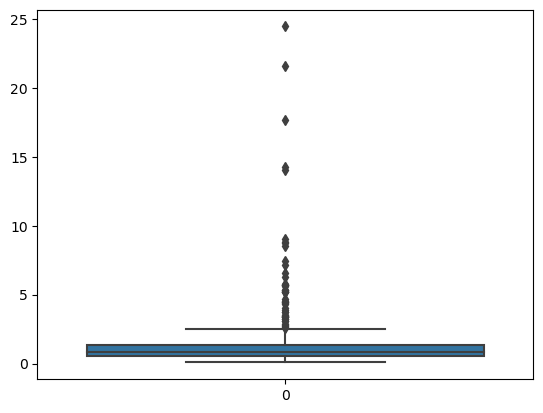

<AxesSubplot: xlabel='outlier_score_min', ylabel='Count'>

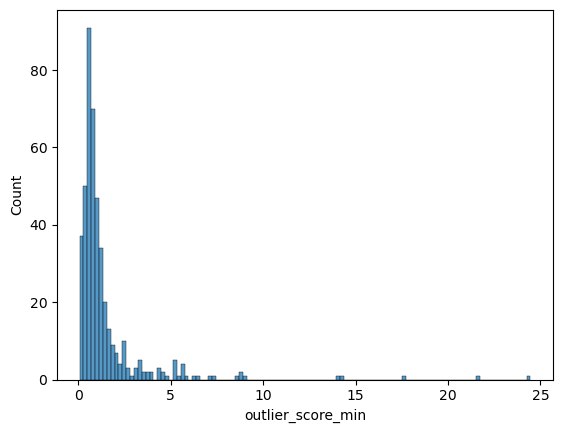

In [13]:
print(np.var(df_overview['outlier_score_min']))
display(df_overview[["outlier_score_min"]].describe())
sns.boxplot(df_overview["outlier_score_min"])
plt.show()
sns.histplot(df_overview["outlier_score_min"])
# want it to be centered/dense!

## Soft-Min Score/KDE approach

In [14]:
nbrs = NearestNeighbors(n_neighbors=len(df), algorithm="ball_tree").fit(df)
distances, indices = nbrs.kneighbors(df)
distances = np.square(distances)
gamma = 1

def softmin(z, gamma):
    # return -1 / gamma * np.log(1 / (len(z) - 1) * np.sum(np.exp(-gamma * z)))
    return -1 * np.log(1 / (len(z) - 1) * np.sum(np.exp(-gamma * z)))


df_overview["outlier_score_softmin"] = np.apply_along_axis(softmin, 1, distances[:, 1:], gamma)
df_overview.sort_values(by="outlier_score_softmin", ascending=False).head(10)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,outlier_score_min,outlier_score_softmin
338,1.386294,5.811141,8.856803,9.655154,2.772589,6.311735,24.462058,30.537021
75,9.923241,7.037028,1.386294,8.391176,1.386294,6.883463,21.598732,27.074911
154,6.434547,4.025352,4.927254,4.330733,2.079442,2.197225,17.656426,23.693326
142,10.519673,8.875287,9.018453,8.005033,3.044522,1.386294,14.249027,20.321837
95,1.386294,7.979681,8.740817,6.089045,5.411646,6.565265,14.033121,20.107723
187,7.799343,8.987572,9.192176,8.743532,8.149024,1.386294,9.006401,14.740212
183,10.514557,10.690831,9.912001,10.506026,5.480639,10.777789,8.742070,14.556361
128,4.948760,9.087947,8.249052,4.962845,6.968850,1.386294,8.841779,14.214246
204,7.579168,6.793466,8.561593,7.232733,1.791759,7.192182,8.531557,13.480020
109,7.249215,9.724959,10.274603,6.513230,6.729824,1.386294,7.406475,12.812801


In [15]:
print(distances.shape)

print(np.sum(distances == 0))
distances # aufsteigende Reihenfolge, indices enthält die zugehörigen Indices

(440, 440)
440


array([[  0.        ,   1.18144472,   1.40267552, ..., 111.51568135,
        113.26455887, 121.64970847],
       [  0.        ,   0.25717029,   0.26772051, ..., 101.91089368,
        112.5661583 , 124.61456054],
       [  0.        ,   1.30272172,   1.37017949, ..., 104.67219589,
        113.37943581, 141.95057146],
       ...,
       [  0.        ,   0.96630544,   1.53277912, ..., 144.9983284 ,
        158.75403274, 159.99341285],
       [  0.        ,   0.7812449 ,   0.78166696, ...,  74.3436262 ,
         80.65129461,  80.86853978],
       [  0.        ,   5.64116508,   6.10735844, ...,  93.45774133,
         94.64201317, 108.30074901]])

7.918142665488302


,outlier_score_softmin
count,440.000000
mean,5.586344
std,2.817123
min,3.372524
25%,4.105058
50%,4.839280
75%,5.909640
max,30.537021


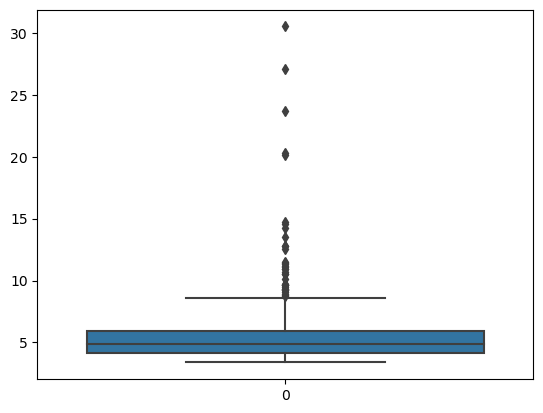

<AxesSubplot: xlabel='outlier_score_softmin', ylabel='Count'>

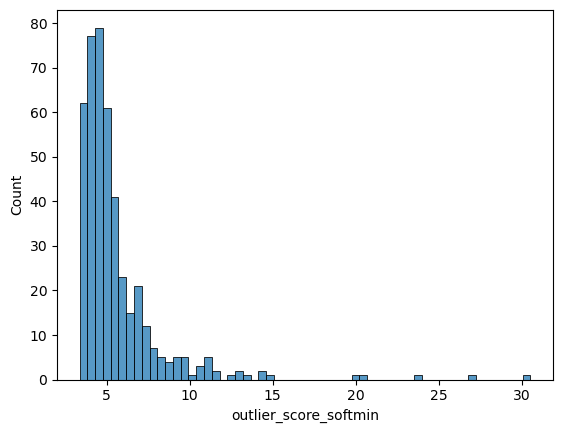

In [16]:
# TODO: Nebeneinander packe

print(np.var(df_overview['outlier_score_softmin']))
display(df_overview[["outlier_score_softmin"]].describe())
sns.boxplot(df_overview["outlier_score_softmin"])
plt.show()
sns.histplot(df_overview["outlier_score_softmin"])

Text(0, 0.5, 'softmin')

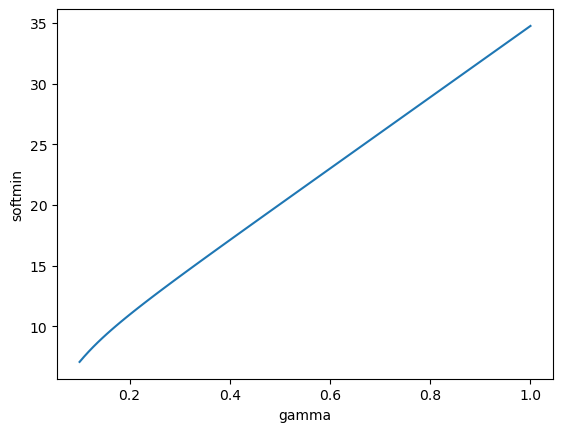

In [145]:
# visualize softmin function for a selected instance
instance = 338  # 338 has had a high outlier score
gammas = np.linspace(0.1, 2, 100)
g = sns.lineplot(
    x=gammas, y=[softmin(distances[instance, 1:], gamma) for gamma in gammas]
)
g.set_xlabel("gamma")
g.set_ylabel("softmin") 


## Bootstrap/Robustness estimate & choosing bandwidth

In [18]:
# TODO should that be the same?
# import statistics
# statistics.fmean(np.exp(-gamma * distances[0, 1:]))
# softmin(distances[instance, 1:], gamma)

hohes gamma => weniger punkte einbezogen => höhere varianz, weniger bias

niedrigeres gamma => mehr punkte einbezogen (lim => 0 all uniform) => hoher bias, low variance

need 2 measures to compare: robustness vs. value of score (how much it discriminates between outliers and "regular" points); check picture from Montavon. Visual examination/optimal point. Compare to hard min


Cluster = Partition der Daten um sie zusammenzufassen, nicht unbedingt obvious

# TEST FOR ALTERNATIVE TAKE ON EX 2

In [146]:
def softmin_og(z, gamma):
    return -1 / gamma * np.log(1 / (len(z) - 1) * np.sum(np.exp(-gamma * z)))


def clean_distances(z):
    if z[0] == 0:
        return z[1:]
    else:
        return z[0:-1]

In [156]:
N_BOOTSTRAP = 100
gamma_range = np.linspace(0.1, 2, 20)

scores = np.zeros((len(df), N_BOOTSTRAP, len(gamma_range)))


for i in range(0, N_BOOTSTRAP):
    # randomly sample 50% of df
    sample = df.sample(frac=0.5)

    nbrs = NearestNeighbors(n_neighbors=len(sample), algorithm="ball_tree").fit(sample)
    distances, indices = nbrs.kneighbors(df)                                                    # TODO all instanes or only those in sample???
    distances = np.apply_along_axis(clean_distances, 1, distances)
    distances = np.square(distances)

    for j, gamma in enumerate(gamma_range):
        scores[:, i, j] = np.apply_along_axis(softmin_og, 1, distances, gamma)


In [150]:
scores.shape

(440, 100, 20)

array([12.98398882, 10.5150323 ,  8.97295637,  7.92330968,  7.16170157,
        6.58007533,  6.11773691,  5.7387004 ,  5.42050045,  5.1484243 ,
        4.9124085 ,  4.70529804,  4.52183065,  4.35802193,  4.21077988,
        4.07765526,  3.9566745 ,  3.84622453,  3.74497117,  3.65179965])

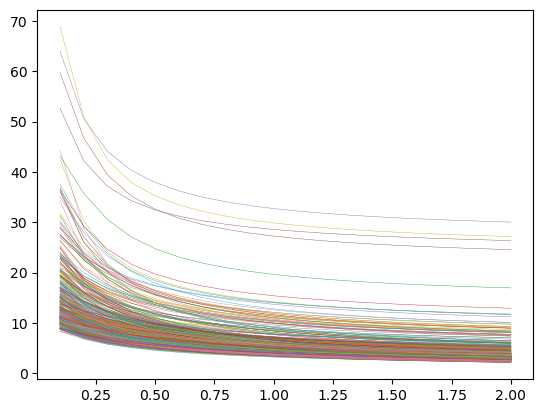

In [157]:
# instance 0, first bootstrap sample, all values for gamma
display(scores[0, 0])

for i in range(len(scores)):
    plt.plot(gamma_range, scores[i, 0], linewidth=0.3)
plt.show()

(440, 20)

Vars of instance 0:


array([0.12988874, 0.09292402, 0.07787732, 0.07048288, 0.06640605,
       0.0637689 , 0.06172452, 0.05990375, 0.05815985, 0.05644632,
       0.05475912, 0.05311006, 0.05151484, 0.04998794, 0.04854065,
       0.04718057, 0.04591188, 0.04473583, 0.04365143, 0.04265601])

Vars of instance 338:


array([ 6.60644355, 23.20510315, 32.42492957, 37.03769021, 39.70914063,
       41.41633239, 42.57981468, 43.4094373 , 44.0213113 , 44.48465949,
       44.84312064, 45.12541595, 45.35110783, 45.53390097, 45.6836271 ,
       45.80748539, 45.91084281, 45.99776454, 46.07137376, 46.13410075])

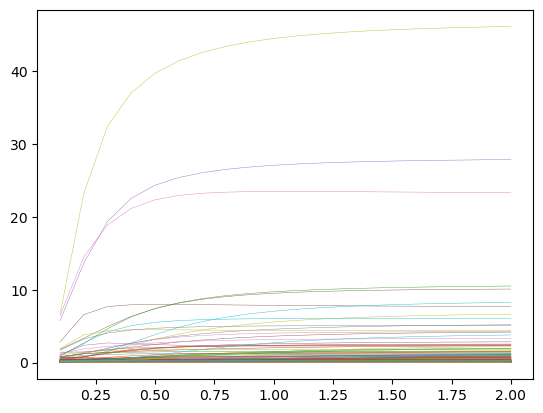

In [158]:
# calculate the spread over bootstrap dimension
spread = np.var(scores, axis=1)

display(spread.shape)
print("Vars of instance 0:")
display(spread[0])

print("Vars of instance 338:")
display(spread[338])

# high values (variances) => anomaly score varied more in bootstrap samples => outlier scoring of instance is not so robust (it varies with sample)

# we want detection to be robust => so to have a low variance during bootstrap experiments

# all spreads per instances
for i in range(len(scores)):
    plt.plot(gamma_range, spread[i], linewidth=0.3)
plt.show()


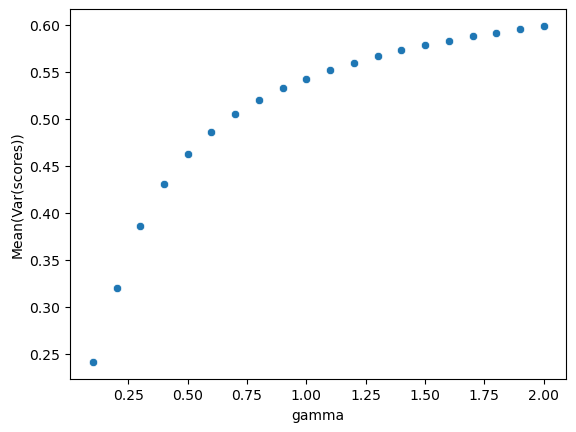

In [183]:
# gamma high => less points taken into account => on average higher variance (and less robust, right?)
g = sns.scatterplot(x=gamma_range, y=np.mean(np.var(scores, axis=1), axis=0))
g.set_xlabel('gamma')
g.set_ylabel('Mean(Var(scores))')
plt.show()

(440, 20)

average outlier score of instance 0:


array([12.76414329, 10.48180451,  9.02004127,  8.00057339,  7.24450913,
        6.65603878,  6.18101527,  5.78708844,  5.45378826,  5.16744531,
        4.91848828,  4.69994102,  4.50654758,  4.33424004,  4.17980092,
        4.04064063,  3.91464536,  3.80006964,  3.6954583 ,  3.59958833])

average outlier score of instance 338:


array([69.62633261, 54.59898236, 47.14110978, 43.08636401, 40.58449414,
       38.89451472, 37.67763307, 36.75968423, 36.0425076 , 35.46666814,
       34.99408885, 34.59924791, 34.26439669, 33.97680908, 33.72712209,
       33.5082937 , 33.31492571, 33.14281059, 32.98862033, 32.84968805])

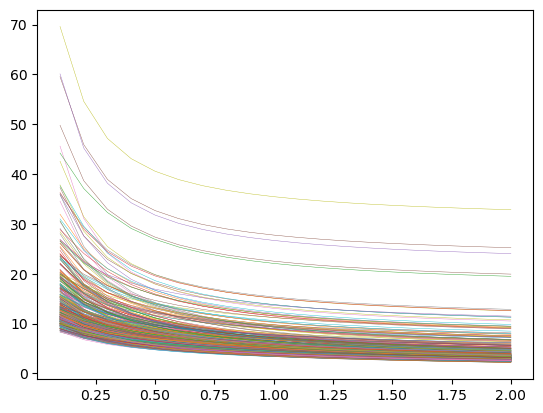

In [192]:
# average outlier score per sample, per gamma
avg_score = np.mean(scores, axis=1)

# TODO are the actual score values event meaningful? the range seems to depend on gamma 
# maybe the resulting ranking is more interesting?


display(avg_score.shape)
print("average outlier score of instance 0:")
display(avg_score[0])

print("average outlier score of instance 338:")
display(avg_score[338])

# high gamma => less values are taken into account => TODO seems to result in lower average outlier score (due to influence of gamma) but why?

# all avg_scores per instances
for i in range(len(scores)):
    plt.plot(gamma_range, avg_score[i], linewidth=0.3)
plt.show()


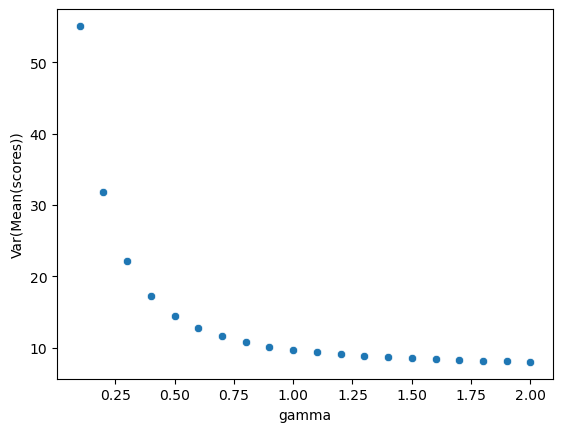

In [191]:
g = sns.scatterplot(x=gamma_range, y=np.var(np.mean(scores, axis=1), axis=0))
g.set_xlabel('gamma')
g.set_ylabel('Var(Mean(scores))')
plt.show()

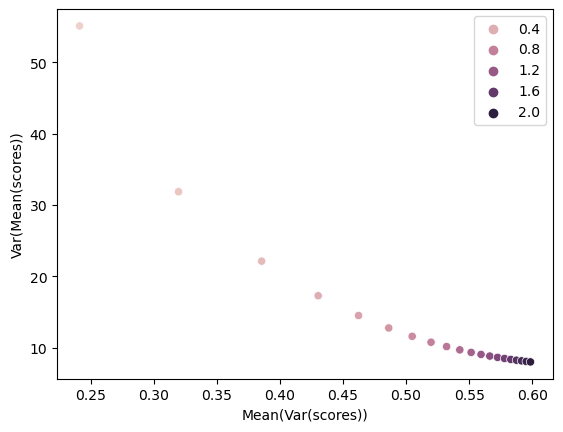

In [182]:
g = sns.scatterplot(x=np.mean(np.var(scores, axis=1), axis=0), y=np.var(np.mean(scores, axis=1), axis=0), hue=gamma_range)
g.set_xlabel('Mean(Var(scores))')
g.set_ylabel('Var(Mean(scores))')
plt.show()

In [39]:
# TODO hard-min adden
# TODO ask about 1/gamma in softmin 

# var(mean(scores)) == discriminatory power ?
# mean(var(scores)) == model var?

# 3 Explaining Anomalies

In [345]:
gamma = 1

nbrs = NearestNeighbors(n_neighbors=len(df), algorithm="ball_tree").fit(df)
distances, indices = nbrs.kneighbors(df)

z = np.square(distances[:, 1:])

# First, one identifies to what extent each data point has contributed to the anomaly score of instance j

# calculate anomaly score
yj = np.apply_along_axis(softmin, 1, z, gamma)

# # caculate squared euclidean norms
# zk = np.square(distances[:, 1:])

# temp = np.exp(-gamma * zk)
# Rkj = temp / np.sum(temp, axis=1)[:, None] * yj[:, None]
# Rkj

In [356]:
# TEST FOR SINGLE INSTANCE
j = 0
gamma = 1

x = df.to_numpy()


z = np.square(np.linalg.norm(x - x[j], axis = 1))

mask = np.full((z.shape), True)
mask[j] = False

y = softmin_og(z[mask], gamma)

temp = np.exp(-gamma * z[mask])

# 1.
Rk = temp / np.sum(temp) * yj[j]

# 2.
nom = np.square(x-x[j])[mask]
denom = np.square(np.linalg.norm(x - x[j], axis = 1))[mask]

print(y)
np.sum(np.sum(nom / denom[:, None] * Rk[:, None], axis=0))


5.0984655205477605


5.098465520547762

In [357]:
Rji = np.zeros((440, 6))

for j in range(len(df)):


    z = np.square(np.linalg.norm(x - x[j], axis = 1))

    mask = np.full((z.shape), True)
    mask[j] = False

    y = softmin_og(z[mask], gamma)

    temp = np.exp(-gamma * z[mask])

    # 1.
    Rk = temp / np.sum(temp) * yj[j]

    # 2.
    nom = np.square(x-x[j])[mask]
    denom = np.square(np.linalg.norm(x - x[j], axis = 1))[mask]

    Rji[j,:] = np.sum(nom / denom[:, None] * Rk[:, None], axis=0)


Rji

array([[0.97708824, 0.70086   , 0.30715632, 1.98429307, 0.54102263,
        0.58804525],
       [0.87977437, 0.68590289, 0.2663898 , 0.75728761, 0.49661036,
        0.40497956],
       [0.80973435, 0.59617754, 0.26501796, 0.56674391, 0.42573516,
        2.43663495],
       ...,
       [0.60323295, 0.41398098, 0.59234194, 2.16930477, 0.92389153,
        0.85754487],
       [0.87115651, 0.51320725, 0.32327539, 0.93878761, 0.43572066,
        1.07212553],
       [1.61807967, 1.04480442, 1.55818045, 2.86021309, 0.60684398,
        2.85320856]])

/var/folders/d7/6rwzv4n55v385stdz71392180000gn/T/ipykernel_83003/219968405.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)


Text(0.5, 0, 't-SNE 2')

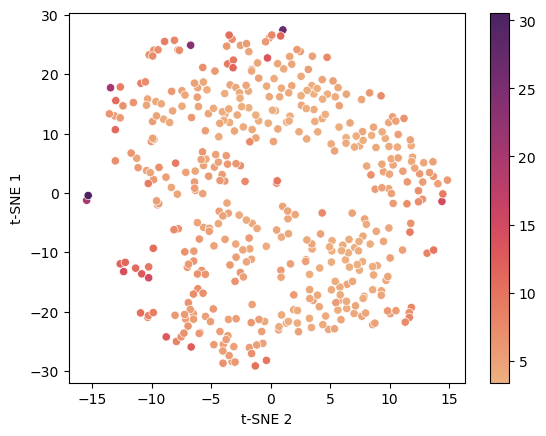

In [358]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30).fit_transform(df)

ax = sns.scatterplot(x=X_embedded[:,1], y=X_embedded[:,0], hue=yj, palette='flare')

norm = plt.Normalize(yj.min(), yj.max())
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

ax.set_ylabel("t-SNE 1")
ax.set_xlabel("t-SNE 2")

Fresh               1.386294
Milk                5.811141
Grocery             8.856803
Frozen              9.655154
Detergents_Paper    2.772589
Delicassen          6.311735
Name: 338, dtype: float64

(0.007371451663191022, 21.410723241623632)

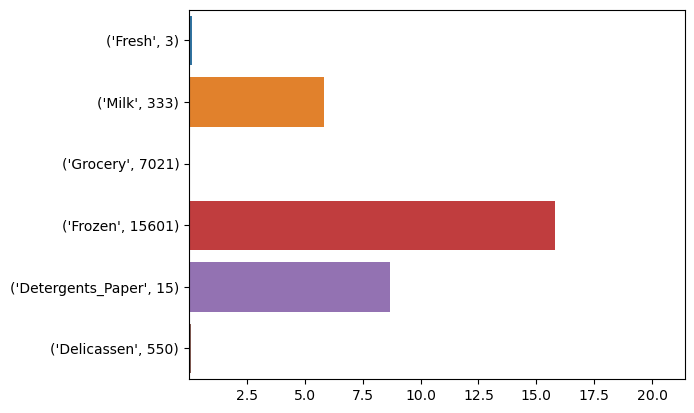

In [359]:
instance = 338
display(df.iloc[instance])
g = sns.barplot(x=Rji[instance], y=list(map(str, list(zip(df_og.iloc[instance].index, df_og.iloc[instance].values)))))
g.set_xlim(np.min(Rji),np.max(Rji))